3.	Необходимо написать на базе BERT определитель жанра фильма: 
a.	На вход подается сюжет фильма. На выходе - жанр 
sample: https://www.kaggle.com/balraj98/movie-genre-prediction-from-wiki-plot-using-bert 

<h1><center>Movie Genre Prediction from Wiki Movie Plots</center></h1>

# Introduction

#### In this notebook, we use [BERT](https://arxiv.org/abs/1810.04805) Transformer model to predict movie genres from wikipedia movie plots

## Libraries 📚⬇

In [1]:
import numpy as np
import pandas as pd
import os, json, gc, re, random
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

import torch, transformers, tokenizers
torch.__version__, transformers.__version__, tokenizers.__version__

('1.12.1+cpu', '4.21.1', '0.12.1')

### Read CSV Data 📝

In [17]:
movies_df = pd.read_csv("kinopoisk-top250.csv")
movies_df.head()

# overview = plot

,rating,Genre,movie,year,country,rating_ball,Plot,director,screenwriter,actors,url_logo
0,0,Драма,Побег из Шоушенка,1994,США,9.111,Бухгалтер Энди Дюфрейн обвинён в убийстве собс...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Тим Роббинс; Морган Фриман; Боб Гантон; Уильям...,'https://st.kp.yandex.net/images/film_iphone/i...
1,1,Драма,Зеленая миля,1999,США,9.062,Пол Эджкомб — начальник блока смертников в тюр...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Том Хэнкс; Дэвид Морс; Бонни Хант; Майкл Кларк...,'https://st.kp.yandex.net/images/film_iphone/i...
2,2,Драма,Форрест Гамп,1994,США,8.913,От лица главного героя Форреста Гампа; слабоум...,Роберт Земекис,Эрик Рот; Уинстон Грум,Том Хэнкс; Робин Райт; Салли Филд; Гэри Синиз;...,'https://st.kp.yandex.net/images/film_iphone/i...
3,3,Военный,Список Шиндлера,1993,США,8.817,Фильм рассказывает реальную историю загадочног...,Стивен Спилберг,Стивен Зеллиан; Томас Кенилли,Лиам Нисон; Бен Кингсли; Рэйф Файнс; Кэролайн ...,'https://st.kp.yandex.net/images/film_iphone/i...
4,4,Комедия,1+1,2011,Франция,8.807,Пострадав в результате несчастного случая; бог...,Оливье Накаш; Эрик Толедано,Оливье Накаш; Филипп Поццо ди Борго; Эрик Т...,Франсуа Клюзе; Омар Си; Анн Ле Ни; Одри Флеро;...,'https://st.kp.yandex.net/images/film_iphone/i...


## Data Pre-processing ⚙️

In [20]:
# movies_df = movies_df[(movies_df["Origin/Ethnicity"]=="American") | (movies_df["Origin/Ethnicity"]=="British")]
movies_df = movies_df[["Plot", "Genre"]]
# drop_indices = movies_df[movies_df["Genre"] == "unknown" ].index
# movies_df.drop(drop_indices, inplace=True)

# Combine genres: 1) "sci-fi" with "science fiction" &  2) "romantic comedy" with "romance"
# movies_df["Genre"].replace({"sci-fi": "science fiction", "romantic comedy": "romance"}, inplace=True)

# Choosing movie genres based on their frequency
shortlisted_genres = movies_df["Genre"].value_counts().reset_index(name="count").query("count > 2")["index"].tolist()
movies_df = movies_df[movies_df["Genre"].isin(shortlisted_genres)].reset_index(drop=True)

# Shuffle DataFrame
movies_df = movies_df.sample(frac=1).reset_index(drop=True)

# Sample roughly equal number of movie plots from different genres (to reduce class imbalance issues)
movies_df = movies_df.groupby("Genre").head(40).reset_index(drop=True)

label_encoder = LabelEncoder()
movies_df["genre_encoded"] = label_encoder.fit_transform(movies_df["Genre"].tolist())

movies_df = movies_df[["Plot", "Genre", "genre_encoded"]]
movies_df

,Plot,Genre,genre_encoded
0,Детский психиатр Малкольм Кроу сталкивается со...,Триллер,13
1,Обаятельный разбойник Флинн путешествует по жи...,Мюзикл,10
2,Голливуд; 1927 год. Звезда немого кино Джордж ...,Романтика,12
3,Идёт третий год Войн клонов. Галактическая Рес...,Военный,2
4,Школьники Роман и Катя тянутся друг к другу со...,Романтика,12
...,...,...,...
219,Пострадав в результате несчастного случая; бог...,Комедия,7
220,Действие происходит в Париже. Молодая девушка;...,Комедия,7
221,Слевину не везет. Дом опечатан; девушка ушла к...,Триллер,13
222,12-летний Мигель живёт в мексиканской деревушк...,Детский,4


In [33]:
from operator import concat


movies_df["PlotTest"] = concat(movies_df.Genre+' ',movies_df.Plot)
movies_df

,Plot,Genre,genre_encoded,PlotTest
0,Детский психиатр Малкольм Кроу сталкивается со...,Триллер,13,Триллер Детский психиатр Малкольм Кроу сталкив...
1,Обаятельный разбойник Флинн путешествует по жи...,Мюзикл,10,Мюзикл Обаятельный разбойник Флинн путешествуе...
2,Голливуд; 1927 год. Звезда немого кино Джордж ...,Романтика,12,Романтика Голливуд; 1927 год. Звезда немого ки...
3,Идёт третий год Войн клонов. Галактическая Рес...,Военный,2,Военный Идёт третий год Войн клонов. Галактиче...
4,Школьники Роман и Катя тянутся друг к другу со...,Романтика,12,Романтика Школьники Роман и Катя тянутся друг ...
...,...,...,...,...
219,Пострадав в результате несчастного случая; бог...,Комедия,7,Комедия Пострадав в результате несчастного слу...
220,Действие происходит в Париже. Молодая девушка;...,Комедия,7,Комедия Действие происходит в Париже. Молодая ...
221,Слевину не везет. Дом опечатан; девушка ушла к...,Триллер,13,Триллер Слевину не везет. Дом опечатан; девушк...
222,12-летний Мигель живёт в мексиканской деревушк...,Детский,4,Детский 12-летний Мигель живёт в мексиканской ...


## BERT Training & Evaluation 🚞

In [42]:
%%time

from simpletransformers.classification import ClassificationModel

model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 8,
    "num_train_epochs": 10,
}

# Create a ClassificationModel
model = ClassificationModel('bert', 'bert-base-cased', num_labels=len(shortlisted_genres), args=model_args, use_cuda=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

CPU times: total: 2.08 s
Wall time: 6.64 s


In [ ]:
movies_df

In [43]:
%%time

train_df, eval_df = train_test_split(movies_df, test_size=0.3, stratify=movies_df["Genre"], random_state=42)
# train_df, eval_df = train_test_split(movies_df, test_size=0.5, random_state=42)

# Train the model
model.train_model(train_df[["PlotTest", "genre_encoded"]])

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df[["PlotTest", "genre_encoded"]])
print(result)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/156 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_512_16_2


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/68 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_512_16_2


Running Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9525174544539858, 'eval_loss': 0.29667600492636365}


{'mcc': 0.9525174544539858, 'eval_loss': 0.29667600492636365}
CPU times: total: 3h 22min 43s
Wall time: 37min 57s


## Plot Heatmap 📉

### Heatmap (w. labels & annotations)

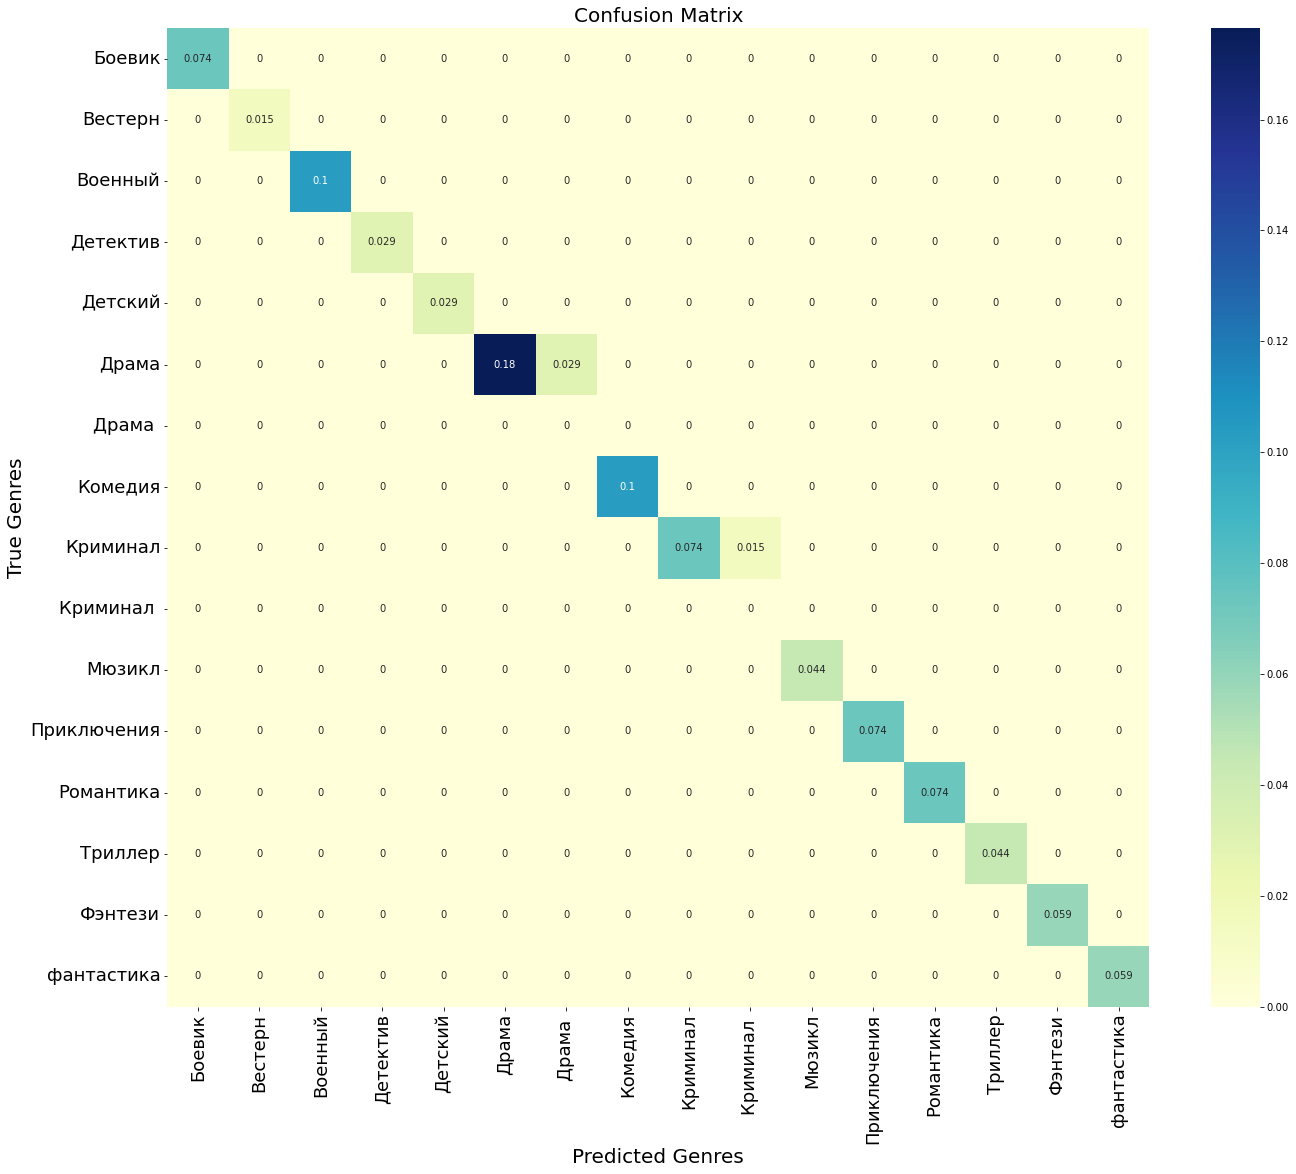

In [44]:
predicted_genres_encoded = list(map(lambda x: np.argmax(x), model_outputs))
predicted_genres = list(label_encoder.inverse_transform(predicted_genres_encoded))
eval_gt_labels = eval_df["Genre"].tolist()
class_labels = list(label_encoder.classes_)

plt.figure(figsize=(22,18))
# cf_matrix = confusion_matrix(predicted_genres, eval_gt_labels, class_labels)
cf_matrix = confusion_matrix(predicted_genres, eval_gt_labels)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap="YlGnBu")
ax.set_xlabel('Predicted Genres', fontsize=20)
ax.set_ylabel('True Genres', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xticklabels(class_labels, rotation=90, fontsize=18)
ax.set_yticklabels(class_labels, rotation=0, fontsize=18)

plt.show()

## Prediction 🔮

In [46]:
x = 20
Pr = 0
for _ in range(x):

    random_idx = random.randint(0, len(eval_df)-1)
    text = eval_df.iloc[random_idx]['Plot']
    true_genre = eval_df.iloc[random_idx]['Genre']

    # Predict with trained multiclass classification model
    predicted_genre_encoded, raw_outputs = model.predict([text])
    predicted_genre_encoded = np.array(predicted_genre_encoded)
    predicted_genre = label_encoder.inverse_transform(predicted_genre_encoded)[0]

    print(f'\nTrue Genre:'.ljust(16,' '), f'{true_genre}\n')
    print(f'Predicted Genre: {predicted_genre}\n')
    print(f'Plot: {text}\n')
    print("-------------------------------------------")
    if true_genre == predicted_genre :
        Pr += 1

print(f'количество тестов - {x}, из них предсказание верно в {Pr} случаях')


INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Драма

Predicted Genre: Романтика

Plot: Потерпев несколько поражений кряду; подававший надежды боксёр-тяжеловес Джим Брэддок вынужден бросить спорт. Во времена Великой депрессии Брэддок берётся за любую работу; чтобы прокормить свою жену Мэй и детей. При этом он всё ещё надеется вернуться на ринг. И однажды ему предоставляется такой шанс. В последнюю минуту Джим заменяет другого боксёра и выходит на поединок с претендентом на титул чемпиона мира…

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Криминал 

Predicted Genre: Комедия

Plot: К Шерлоку Холмсу за помощью обращается некая леди Брекуэлл; одна из жертв известного лондонского шантажиста по имени Чарльз Огестос Милвертон. Если великий сыщик не остановит циничного негодяя; семейное благополучие молодой леди окажется под угрозой. Шерлок Холмс и доктор Ватсон как истинные джентельмены не могут отказать в помощи беззащитной женщине.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Комедия

Predicted Genre: Детский

Plot: Действие происходит в Париже. Молодая девушка; дочь миллионера; втайне промышляющего подделкой произведений искусства; и преступник; должны выкрасть с выставки изобразительного искусства в музее один из «шедевров» отца девушки; чтобы спасти его от разоблачения.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Драма

Predicted Genre: Драма

Plot: Джон Китинг — новый преподаватель английской словесности в консервативном американском колледже. От чопорной массы учителей его выгодно отличают легкость общения; эксцентричное поведение и пренебрежение к программе обучения. Однажды он посвящает своих подопечных в тайну Общества мёртвых поэтов. С этого момента каждый из учеников старается обрести свой собственный голос в безликом хоре; взглянуть на окружающий мир; высоко подпрыгнув над серой школьной оградой.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Мюзикл

Predicted Genre: Драма

Plot: Франция; 1949 год. Отчаявшись найти работу; учитель музыки Клемент Матье попадает в интернат для трудных подростков. Там он видит; к каким жестоким «воспитательным мерам» прибегает ректор этого заведения Рашан. Чем больше издевается Рашан над мальчиками; тем агрессивнее они становятся.Добродушного по натуре Матье возмущают эти методы; но он не в состоянии открыто протестовать. Но однажды ему; автору многочисленных музыкальных произведений; которые он скромно прячет в своей комнате; приходит в голову замечательная идея: организовать школьный хор.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Вестерн

Predicted Genre: Фэнтези

Plot: Эксцентричный охотник за головами; также известный как Дантист; промышляет отстрелом самых опасных преступников. Работенка пыльная; и без надежного помощника ему не обойтись. Но как найти такого и желательно не очень дорогого? Освобождённый им раб по имени Джанго — прекрасная кандидатура. Правда; у нового помощника свои мотивы — кое с чем надо сперва разобраться.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Мюзикл

Predicted Genre: Драма

Plot: Франция; 1949 год. Отчаявшись найти работу; учитель музыки Клемент Матье попадает в интернат для трудных подростков. Там он видит; к каким жестоким «воспитательным мерам» прибегает ректор этого заведения Рашан. Чем больше издевается Рашан над мальчиками; тем агрессивнее они становятся.Добродушного по натуре Матье возмущают эти методы; но он не в состоянии открыто протестовать. Но однажды ему; автору многочисленных музыкальных произведений; которые он скромно прячет в своей комнате; приходит в голову замечательная идея: организовать школьный хор.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Мюзикл

Predicted Genre: Военный

Plot: В заколдованном замке; скрытом в темном лесу; живет ужасное Чудовище. Растопить лед в его сердце и вернуть ему человеческий облик; сняв заклятие; может только прекрасная девушка; которая полюбит его таким; какой он есть.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Комедия

Predicted Genre: Детский

Plot: Действие происходит в Париже. Молодая девушка; дочь миллионера; втайне промышляющего подделкой произведений искусства; и преступник; должны выкрасть с выставки изобразительного искусства в музее один из «шедевров» отца девушки; чтобы спасти его от разоблачения.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Приключения

Predicted Genre: Фэнтези

Plot: В фильме показана жизнь цивилизации майя до прихода испанских конкистадоров: жестокие войны с соседними племенами; человеческие жертвоприношения; загадочные мистические ритуалы.В один день рушится мир индейца по имени Лапа Ягуара. Его деревню захватывает соседнее племя; уничтожая хижины; забирая местных жителей в плен. Его ведут в город; чтобы принести в жертву богам. Перед лицом неминуемой смерти Лапа Ягуара должен побороть свои самые сильные страхи и совершить отчаянный рывок; чтобы спасти то; что ему дорого…

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Драма

Predicted Genre: Романтика

Plot: Ризван Кхан; мусульманин из Индии; переезжает в Сан-Франциско и живет со своим братом и невесткой. Ризван; страдающий от Синдрома Аспергера; влюбляется в Мандиру. Несмотря на протесты его семьи; они женятся и начинают вместе небольшой бизнес. Они живут счастливо до 11 сентября 2001 года; когда отношение к мусульманам резко меняется. Когда происходит трагедия; Мандира оказывается раздавленной и их отношения дают трещину. Ризван растерян и очень расстроен тем; что любовь всей его жизни покинула его. Чтобы вернуть ее; он предпринимает трогательное и вдохновляющее путешествие через всю Америку.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Комедия

Predicted Genre: Романтика

Plot: Американское семейство отправляется из Чикаго в Европу; но в спешке сборов бестолковые родители забывают дома… одного из своих детей. Юное создание; однако; не теряется и демонстрирует чудеса изобретательности. И когда в дом залезают грабители; им приходится не раз пожалеть о встрече с милым крошкой.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Драма

Predicted Genre: Военный

Plot: Закон и преступление; порядок и беспредел; защитник и жертва — неизбежное противостояние и столкновение. Полицейские — порядок; законопослушные граждане — закон. Но все ли граждане; слывущие добропорядочными; соблюдают законы; и всем ли представителям закона стоит доверять? Прикрываясь значком полицейского; они вершат беззаконие и из праведников превращаются в изощренных насильников.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Фэнтези

Predicted Genre: Военный

Plot: В третьей части истории о юном волшебнике полюбившиеся всем герои — Гарри Поттер; Рон и Гермиона — возвращаются уже на третий курс школы чародейства и волшебства Хогвартс. На этот раз они должны раскрыть тайну узника; сбежавшего из зловещей тюрьмы Азкабан; чье пребывание на воле создает для Гарри смертельную опасность…

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Криминал

Predicted Genre: Военный

Plot: Двое бандитов Винсент Вега и Джулс Винфилд ведут философские беседы в перерывах между разборками и решением проблем с должниками криминального босса Марселласа Уоллеса.В первой истории Винсент проводит незабываемый вечер с женой Марселласа Мией. Во второй рассказывается о боксёре Бутче Кулидже; купленном Уоллесом; чтобы сдать бой. В третьей истории Винсент и Джулс по нелепой случайности попадают в неприятности.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Криминал

Predicted Genre: Вестерн

Plot: Четверо молодых парней накопили каждый по 25 тысяч фунтов; чтобы один из них мог сыграть в карты с опытным шулером и матерым преступником; известным по кличке Гарри-Топор. Парень в итоге проиграл 500 тысяч; на уплату долга ему дали неделю.В противном случае и ему и его «спонсорам» каждый день будут отрубать по пальцу; а потом… Чтобы выйти из положения; ребята решили ограбить бандитов; решивших ограбить трех «ботаников»; выращивающих марихуану для местного наркобарона. Но на этом приключения четверки не заканчиваются…

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Криминал 

Predicted Genre: Комедия

Plot: К Шерлоку Холмсу за помощью обращается некая леди Брекуэлл; одна из жертв известного лондонского шантажиста по имени Чарльз Огестос Милвертон. Если великий сыщик не остановит циничного негодяя; семейное благополучие молодой леди окажется под угрозой. Шерлок Холмс и доктор Ватсон как истинные джентельмены не могут отказать в помощи беззащитной женщине.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Драма

Predicted Genre: Военный

Plot: 1960-е годы. После закрытия нью-йоркского ночного клуба на ремонт вышибала Тони по прозвищу Болтун ищет подработку на пару месяцев. Как раз в это время Дон Ширли; утонченный светский лев; богатый и талантливый чернокожий музыкант; исполняющий классическую музыку; собирается в турне по южным штатам; где ещё сильны расистские убеждения и царит сегрегация. Он нанимает Тони в качестве водителя; телохранителя и человека; способного решать текущие проблемы. У этих двоих так мало общего; и эта поездка навсегда изменит жизнь обоих.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Романтика

Predicted Genre: Военный

Plot: В сибирский поселок приехала юная повариха Тося Кислицына — наивная и эксцентричная девчонка. Она сует свой нос во все дела; каждому стремится помочь. Местный красавец Илья на спор заводит с Тосей роман; сопровождающийся массой комичных ситуаций…

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


True Genre:     Детский

Predicted Genre: Детский

Plot: Действие разворачивается 20 тыс. лет назад. Чтобы избежать приближающегося из-за наступления ледникового периода холода; животные мигрируют на юг. Однако некоторые из них всё-таки решают остаться — одинокий; угрюмый мамонт Манфред; а также бесшабашный ленивец Сид.Случайно эта парочка наталкивается на человеческого детёныша. Они решаются вернуть его людям и отправляются в путешествие. По пути они встречают саблезубого хитрого тигра. И теперь этой веселой компании предстоят забавные приключения!

-------------------------------------------
количество тестов - 20, из них предсказание верно в 2 случаях


In [45]:
for _ in range(10):

    random_idx = random.randint(0, len(eval_df)-1)
    text = eval_df.iloc[random_idx]['PlotTest']
    true_genre = eval_df.iloc[random_idx]['Genre']

    # Predict with trained multiclass classification model
    predicted_genre_encoded, raw_outputs = model.predict([text])
    predicted_genre_encoded = np.array(predicted_genre_encoded)
    predicted_genre = label_encoder.inverse_transform(predicted_genre_encoded)[0]

    print(f'\nTrue Genre:'.ljust(16,' '), f'{true_genre}\n')
    print(f'Predicted Genre: {predicted_genre}\n')
    print(f'Plot: {text}\n')
    print("-------------------------------------------")

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Драма

Predicted Genre: Драма

Plot: Драма Ризван Кхан; мусульманин из Индии; переезжает в Сан-Франциско и живет со своим братом и невесткой. Ризван; страдающий от Синдрома Аспергера; влюбляется в Мандиру. Несмотря на протесты его семьи; они женятся и начинают вместе небольшой бизнес. Они живут счастливо до 11 сентября 2001 года; когда отношение к мусульманам резко меняется. Когда происходит трагедия; Мандира оказывается раздавленной и их отношения дают трещину. Ризван растерян и очень расстроен тем; что любовь всей его жизни покинула его. Чтобы вернуть ее; он предпринимает трогательное и вдохновляющее путешествие через всю Америку.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Драма

Predicted Genre: Драма

Plot: Драма Закон и преступление; порядок и беспредел; защитник и жертва — неизбежное противостояние и столкновение. Полицейские — порядок; законопослушные граждане — закон. Но все ли граждане; слывущие добропорядочными; соблюдают законы; и всем ли представителям закона стоит доверять? Прикрываясь значком полицейского; они вершат беззаконие и из праведников превращаются в изощренных насильников.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Драма

Predicted Genre: Драма

Plot: Драма Ризван Кхан; мусульманин из Индии; переезжает в Сан-Франциско и живет со своим братом и невесткой. Ризван; страдающий от Синдрома Аспергера; влюбляется в Мандиру. Несмотря на протесты его семьи; они женятся и начинают вместе небольшой бизнес. Они живут счастливо до 11 сентября 2001 года; когда отношение к мусульманам резко меняется. Когда происходит трагедия; Мандира оказывается раздавленной и их отношения дают трещину. Ризван растерян и очень расстроен тем; что любовь всей его жизни покинула его. Чтобы вернуть ее; он предпринимает трогательное и вдохновляющее путешествие через всю Америку.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Детский

Predicted Genre: Детский

Plot: Детский Добро пожаловать в Зверополис — современный город; населенный самыми разными животными; от огромных слонов до крошечных мышек. Зверополис разделен на районы; полностью повторяющие естественную среду обитания разных жителей — здесь есть и элитный район Площадь Сахары и неприветливый Тундратаун. В этом городе появляется новый офицер полиции; жизнерадостная зайчиха Джуди Хоппс; которая с первых дней работы понимает; как сложно быть маленькой и пушистой среди больших и сильных полицейских. Джуди хватается за первую же возможность проявить себя; несмотря на то; что ее партнером будет болтливый хитрый лис Ник Уайлд. Вдвоем им предстоит раскрыть сложное дело; от которого будет зависеть судьба всех обитателей Зверополиса.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Приключения

Predicted Genre: Приключения

Plot: Приключения Продолжение путешествия хоббита Бильбо Бэггинса; волшебника Гэндальфа и 13 отважных гномов. Их компания должна добраться до Одинокой горы. А там они встретятся с величайшей опасностью из всех — созданием куда более ужасающим; чем все их прошлые противники; чудовищем; которое проверит на прочность не только их мужество; но крепость их дружбы и правильность выбранного пути; — драконом Смаугом.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Драма

Predicted Genre: Драма

Plot: Драма Юная Грейс; сбежав от банды гангстеров; находит спасение в маленьком городке Догвилль где-то в Скалистых горах. Местные жители — один прекраснее другого — готовы ее укрыть. А взамен им совсем ничего не надо; ну; разве что помочь по дому или присмотреть за детьми. Но постепенно милый Догвилль превращается для девушки в тюрьму.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Драма

Predicted Genre: Драма

Plot: Драма Потерпев несколько поражений кряду; подававший надежды боксёр-тяжеловес Джим Брэддок вынужден бросить спорт. Во времена Великой депрессии Брэддок берётся за любую работу; чтобы прокормить свою жену Мэй и детей. При этом он всё ещё надеется вернуться на ринг. И однажды ему предоставляется такой шанс. В последнюю минуту Джим заменяет другого боксёра и выходит на поединок с претендентом на титул чемпиона мира…

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Фэнтези

Predicted Genre: Фэнтези

Plot: Фэнтези В третьей части истории о юном волшебнике полюбившиеся всем герои — Гарри Поттер; Рон и Гермиона — возвращаются уже на третий курс школы чародейства и волшебства Хогвартс. На этот раз они должны раскрыть тайну узника; сбежавшего из зловещей тюрьмы Азкабан; чье пребывание на воле создает для Гарри смертельную опасность…

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



True Genre:     Криминал

Predicted Genre: Криминал

Plot: Криминал Двое бандитов Винсент Вега и Джулс Винфилд ведут философские беседы в перерывах между разборками и решением проблем с должниками криминального босса Марселласа Уоллеса.В первой истории Винсент проводит незабываемый вечер с женой Марселласа Мией. Во второй рассказывается о боксёре Бутче Кулидже; купленном Уоллесом; чтобы сдать бой. В третьей истории Винсент и Джулс по нелепой случайности попадают в неприятности.

-------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


True Genre:     Драма

Predicted Genre: Драма

Plot: Драма Доктор Малколм Сэйер; застенчивый врач и ученый; использует экспериментальные препараты; чтобы «пробуждать» обездвиженных жертв редкого заболевания. Леонард был первым пациентом; получившим это неопробованное лечение. Его пробуждение; наполненное благоговением; страхом и энтузиазмом; приводят как бы ко второму рождению и самого Сэйера по мере того; как пациент открывает для себя и доктора простые радости жизни. Воодушевленный чудесным выздоровлением Леонарда; Сэйер дает лекарство другим больным.

-------------------------------------------
